### (Step 1) Create random MDP task structure given predefined parameters.

MDP is defined as 5-tuple $\left(S,A,P_a,R_a,\gamma\right)$. Algorithm creates random transition probability matrices, and reward matrices for each action $a\in A$. Expected reward depends on realized 3-tuple $(s,a,s')$, where $s,s'\in S$. Therefore, entire MDP comprised of $N=|S|$ states can be completely represented by four $N\times N$ square matrices:
- `P_left` transition probability matrix after choosing $a=L$
- `P_right` transition probability matrix after choosing $a=R$
- `Rval_left` and `Runc_left` reward matrix and reward noise matrix after choosing $a=L$
- `Rval_right` and `Runc_right` reward matrix and reward noise matrix after choosing $a=R$

In [104]:
%reset -f 
import numpy as np
import random

#=== MDP parameters ===
#--- system dynamics
N_states = 5 
tran_possib = [[.5,.5]]          # possible transition probabilities
tran_determ_frac = 0.5           # proportion of deterministic transitions
#--- reward dynamics
reward_trans_frac = 1/3          # proportion of rewarded transitions 
reward_noise = [1,2]             # possible reward noise
reward_mean = 2                  # mean reward for rewarded transitions

#=== TRANSITION PROBABILITY MATRIX ===
#--- create empty transition probability matrix for all actions
P = np.zeros([2*N_states, N_states])
#--- ensure that all states are reachable and escape'able
while (0 in np.sum(P, axis=0)) or (2 in np.diag(P[0:N_states]+P[N_states:])):
    P = np.zeros([2*N_states, N_states])
    #--- number of deterministic transitions for all 2N (s,a) pairs
    N_tran_determ = int(np.ceil(2 * N_states * tran_determ_frac))
    #--- store transition types (deterministic [code -1] vs. probabilistic [code 0,1,...])
    tran_type = np.concatenate(((-1)*np.ones(N_tran_determ),
                                [random.randint(0, len(tran_possib)-1) for trans in range(2*N_states - N_tran_determ)]))
    np.random.shuffle(tran_type)
    #--- fill transition matrices
    for s in range(2*N_states):
        if tran_type[s] == -1:
            #--- deterministic transition to random successor state
            P[s][random.randint(0, N_states-1)] = 1
        else:
            newrow = np.concatenate((tran_possib[int(tran_type[s])],
                                    np.zeros(N_states-len(tran_possib[int(tran_type[1])]))))
            np.random.shuffle(newrow)
            P[s] = newrow
#--- divide matrices 
P_left = P[0:N_states]
P_right = P[N_states:]

#=== REWARD VALUE and REWARD UNCERTAINTY MATRIX ===
N_trans = np.sum(P>0)
#--- number of rewarded transitions
N_reward_trans = int(np.sum(P>0)*reward_trans_frac)
#--- store reward values and their uncertainties
reward_val = np.concatenate((np.random.multinomial(N_reward_trans*reward_mean, np.ones(N_reward_trans)/N_reward_trans, size=1)[0],
                            np.zeros(N_trans-N_reward_trans)))
reward_unc = np.concatenate(([reward_noise[random.randint(0,len(reward_noise)-1)] for i in range(N_reward_trans)],
                            np.zeros(N_trans-N_reward_trans)))
reward_info = np.vstack([reward_val, reward_unc])
reward_info = np.random.permutation(reward_info.T).T
#--- create empty reward matrix and reward uncertainty matrix for all actions
Rval = np.zeros([2*N_states, N_states])
Runc = np.zeros([2*N_states, N_states])
#--- loop over transition probability matrix
k = 0
for idx in range(P.shape[0]):
    for idy in range(P.shape[1]):
        if P[idx,idy]>0:
            Rval[idx,idy] = reward_info[0][k]
            Runc[idx,idy] = reward_info[1][k]
            k += 1
#--- divide matrices
Rval_left = Rval[0:N_states]
Rval_right = Rval[N_states:]
Runc_left = Runc[0:N_states]
Runc_right = Runc[N_states:]

In [119]:
#=== Loading random stimuli
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from random import shuffle

#--- path to stimuli folder
stimuli_path = 'stimuli/'

#--- get stimuli and randomly draw N_states
icon = os.listdir(stimuli_path)
shuffle(icon)
icon = [f'{stimuli_path}{icon[idx]}' for idx in range(N_states)]

def drawstate(icon, index, size):
    #--- read image
    img = mpimg.imread(icon[index])
    #--- draw image
    fig, ax = plt.subplots(figsize=(size, size))
    ax.imshow(img)
    plt.axis('off');
    plt.show()

### (Step 2) Try out MDP task!

Load predefined game settings.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

N_states = 5

def drawstate(icon, index, size):
    #--- read image
    img = mpimg.imread(icon[index])
    #--- draw image
    fig, ax = plt.subplots(figsize=(size, size))
    ax.imshow(img)
    plt.axis('off');
    plt.show()
    
#--- transition probability matrix
P_right = [[0   , 0.75, 0.25, 0,    0   ],
           [0   , 0   , 0.  , 0.5 , 0.5 ],
           [0.25, 0   , 0.75, 0   , 0   ], #self rewarding loop
           [0   , 1   , 0.  , 0   , 0   ],
           [0   , 0   , 0.  , 1   , 0   ]]
P_left = [[1   , 0   , 0   , 0   , 0   ],
          [0   , 0.5 , 0   , 0   , 0.5 ],
          [1   , 0   , 0   , 0   , 0   ],
          [0.  , 0   , 0   , 0   , 1   ],
          [0   , 0.5 , 0.5 , 0   , 0   ]]

#--- reward matrix
Rval_right = [[0 , 0 , 0 , 0 , 0 ],
              [0 , 0 , 0 , 1 , 0 ],
              [0 , 0 , .5, 0 , 0 ], #self reward magnitude
              [0 , 0 , 0 , 0 , 0 ],
              [0 , 0 , 0 , 0 , 0 ]]
Rval_left = [[0 , 0 , 0 , 0 , 0 ], 
             [0 , 0 , 0 , 0 , 0 ],
             [0 , 0 , 0 , 0 , 0 ],
             [0 , 0 , 0 , 0 , -1], #penalty
             [0 , 3 , 6 , 0 , 0 ]]

#--- reward noise matrix
Runc_right = [[0 , 0 , 0 , 0 , 0 ],
              [0 , 0 , 0 , 1 , 0 ],
              [0 , 0 , 0 , 0 , 0 ], #self rewarding variability 
              [0 , 0 , 0 , 0 , 0 ],
              [0 , 0 , 0 , 0 , 0 ]]
Runc_left = [[1 , 0 , 0 , 0 , 0 ], #noisy self-loop
             [0 , 0 , 0 , 0 , 0 ],
             [0 , 0 , 0 , 0 , 0 ],
             [0 , 0 , 0 , 0 , 0 ], #penalty noise 
             [0 , 1 , 2 , 0 , 0 ]] #big rewards

P_right = np.asarray(P_right)
P_left = np.asarray(P_left)
Rval_right = np.asarray(Rval_right)
Rval_left = np.asarray(Rval_left)

#--- stimulis 
icon = ['stimuli/icons8-MouseAnimal-96.png',      # s0
        'stimuli/icons8-Chewbacca-96.png',        # s1 
        'stimuli/icons8-SockPuppet-96.png',       # s2
        'stimuli/icons8-UgandanKnuckles-96.png',  # s3
        'stimuli/icons8-Bastet-96.png']           # s4

### Run code below to play the game!

In [2]:
#=== Run task!
from IPython.display import clear_output
import random
import time

#--- settings 
N_trials = 180
t_isi = 3

#--- reset game history 
state_history = np.zeros(N_trials+1)
reward_history = np.zeros(N_trials+1); reward_history[0] = 0
decision_history = ['none']

#--- set initial state and reset trial counter
trial = 0
current_state = random.randint(0,N_states-1)
state_history[trial] = current_state

#--- welcome screen
print('Welcome my friend!')
name = input('Write your name, and press enter.')

for t in range(N_trials):
    #=== choice phase ===
    clear_output()
    print(f'Account: {np.round(sum(reward_history),1)}')
    drawstate(icon, current_state, size=3)
    decision = 0
    while not (decision == '4' or decision == '6'): 
        decision = input('Choose?')
    #====================

    #--- choose transition & reward    
    if decision == '4': #left
        next_state = np.random.choice(N_states, 1, p=P_left[current_state])[0]
        r = Rval_left[current_state][next_state] + np.round(np.random.normal(loc=0, scale=Runc_left[current_state][next_state]), 1)
    elif decision == '6': #right
        next_state = np.random.choice(N_states, 1, p=P_right[current_state])[0]
        r = Rval_right[current_state][next_state] + np.round(np.random.normal(loc=0, scale=Runc_right[current_state][next_state]), 1)
    #--- update history
    reward_history[trial+1] += r
    state_history[trial+1] = next_state
    decision_history.append(decision)

    #=== outcome phase ===
    clear_output()
    print(f'Reward: {np.round(r,1)}')
    print(f'Account: {np.round(sum(reward_history),1)}')
    drawstate(icon, next_state, size=1)
    #--- update timestep
    trial += 1
    current_state = next_state
    time.sleep(t_isi)
    #=====================

#--- end screen 
clear_output()
print('Task complete, thank you for participation!')
print(f'You collected {np.round(sum(reward_history),1)} points')

#--- save task data for participant
import pandas as pd

d = {'states': state_history,
    'decisions': decision_history,
    'rewards': reward_history}
df = pd.DataFrame(d)
df.to_csv(f'{name+"_mdptask.log"}', sep='\t')

Task complete, thank you for participation!
You collected 149.6 points


### (Step 3) Solve MDP using value iteration algorithm
- Input: system dynamics (`P_right`,`P_left`), reward function (`Rval_left`,`Rval_right`)

- Output: optimal policy $\pi_*$ and value function $v_*$

In value iteration following update is performed at each algorithm step 
$$v_{k+1}(s) = \max\limits_{a \in A}\left(R^a_s+\gamma\sum\limits_{s'\in S}P^a_{ss'}v_k\left( s'\right)\right)$$


=== P(a=R) ===
[[0.   0.75 0.25 0.   0.  ]
 [0.   0.   0.   0.5  0.5 ]
 [0.25 0.   0.75 0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]]

=== P(a=L) ===
[[1.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.5]
 [1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.5 0.5 0.  0. ]]

=== R(a=R) ===
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]

=== R(a=L) ===
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0 -1]
 [ 0  3  6  0  0]]

State representations.

State 0:


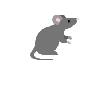

State 1:


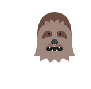

State 2:


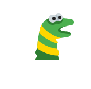

State 3:


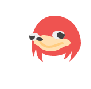

State 4:


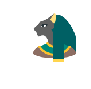

In [42]:
#=== Show MDP ===
system = [P_right, P_left, Rval_right, Rval_left]
labels = ['P(a=R)', 'P(a=L)', 'R(a=R)', 'R(a=L)']

for idx, mat in enumerate(system):
    print(f'\n=== {labels[idx]} ===')
    print(mat)

print('\nState representations.\n')    
    
for s in range(N_states):
    print(f'State {s}:')
    drawstate(icon, s, 1)

In [43]:
gamma = .7 # discount rate 
value = np.zeros(N_states)

#--- implementation details
eps = .0001    # stopping condition
delta = 2*eps  # initialize 
iteration = 0  # counter

#--- value iteration algorithm
while delta > eps:
    #--- increment counter
    iteration += 1
    #--- calculate one step lookahead for both actions
    v_left = np.sum(np.multiply(P_left,Rval_left), axis=1) + gamma * np.sum(np.multiply(P_left,value), axis=1)
    v_right = np.sum(np.multiply(P_right,Rval_right), axis=1) + gamma * np.sum(np.multiply(P_right,value), axis=1)
    #--- max over actions
    v_new = np.maximum(v_left,v_right)
    #--- update
    delta = np.sum(abs(value - v_new))
    value = v_new

#--- get optimal policy     
opt_policy = ['L'*int(b)+'R'*int(not b) for b in v_left > v_right]

value = np.round(value, decimals=2)
print(f'Solution found after {iteration} iterations!')
print(f'Value function = {value}')
print(f'Optimal policy = {opt_policy}')

Solution found after 32 iterations!
Value function = [2.4  4.01 1.68 3.55 6.49]
Optimal policy = ['R', 'R', 'L', 'L', 'L']
